# Hueristic strategy movie

In [2]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code


In [3]:
import scipy.io as spio
mat = spio.loadmat('../../exp_data/Thura_etal_2016/toktrials.mat', squeeze_me=True)
mat['toktrials'].flatten().dtype.names
col_names=mat['toktrials'].flatten().dtype.names
df_data=pd.DataFrame(columns=col_names)
for col_name in col_names:
    df_data[col_name]=mat['toktrials'].flatten()[0][col_name]

In [14]:
from seaborn import color_palette

In [5]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [6]:
from lib.lib import get_trajs,get_pt_plus

In [7]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=7.5#para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0
alp_slow=1/4
alp_fast=3/4
alpvec=np.asarray([alp_slow,alp_fast])

In [78]:
df_traj=get_trajs()
df_traj.head()
def dummy(Nt_seq):
    return np.array([(get_pt_plus(t,Nt) if Nt>=0 else 1-get_pt_plus(t,Nt)) for t,Nt in enumerate(Nt_seq)])
# df_traj['p_suc_seq']=df_traj.Nt.apply(lambda x: dummy(x))
# df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
# df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [9]:
def filter_step(filtered_value,input_sample,inter_event_interval,filter_factor): #filter factor is 1/(1+filter_timescale)
    tmp=np.power(1-filter_factor,inter_event_interval)
    return tmp*filtered_value+(1-tmp)*input_sample 

def get_trial_duration(t,alpha):
    return t+(1-alpha)*(para['T']-t)+para['T_ITI']

still frame

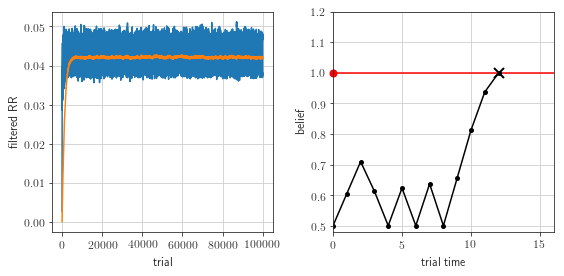

In [36]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
rho_long=0
rho_short=0
T_short=0

trial_time_vec=np.arange(para['T']+2)
urgency=rho_long*trial_time_vec+(rho_short-rho_long)*T_short

ax[1].plot(trial_time_vec,1-urgency,'r-')
ax[1].plot([0],[1-urgency[0]],'ro',clip_on=False)
ax[1].set_ylim(0.48,1.2)
ax[1].set_xlim(0,para['T']+1)

sample_trial=df_traj.sample().iloc[0]
t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
ax[1].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'k.-')
# ax[0,3].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'ko-')
ax[1].plot([t_decision],[sample_trial.p_suc_seq[t_decision]],'kx',ms=10,clip_on=False)
ax[1].set_ylabel('belief')
ax[1].set_xlabel('trial time')

ax[0].plot(rho_context_store)
ax[0].plot(rho_long_store)
ax[0].set_xlabel('trial')
ax[0].set_ylabel('filtered RR')
fig.tight_layout()

In [10]:
from IPython import display

In [11]:
import matplotlib as mpl

In [57]:
import subprocess

In [75]:
from lib.filter_lib import get_contextaware_oppcost_boundary

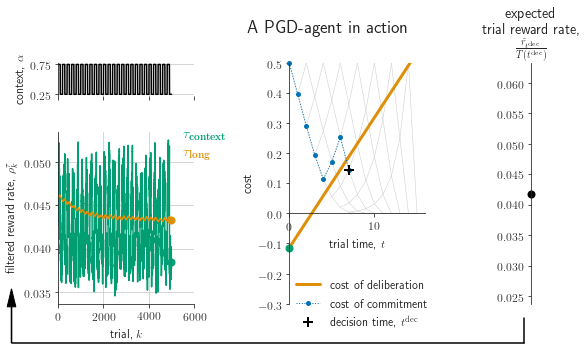

617.4837281703949


In [89]:
max_trial_iter=int(5e3)
trials_per_context=100
context_seq=np.tile(np.concatenate((np.zeros(trials_per_context,dtype=int),np.ones(trials_per_context,dtype=int))),int(max_trial_iter/trials_per_context/2))
nPostIntervalvec=[150,50]

num_blocks=int(max_trial_iter/trials_per_context)
alpha_sequence=np.zeros(num_blocks)
alpha_sequence[1::2]=1/4
alpha_sequence[::2]=3/4
alpha_sequence=np.repeat(alpha_sequence,[trials_per_context]*num_blocks)
num_trials=len(alpha_sequence)

np.random.seed(0)
df_sim=df_traj.sample(num_trials,replace=True).reset_index(drop=True)
df_sim['nPostInterval']=(1-alpha_sequence)*200
# average_trial_duration=get_trial_duration(6,0.5)
# tau_context=average_trial_duration*20
# tau_long=10*trials_per_context*average_trial_duration
model_paras={'tau_context':20*10, #about trial duration x10
                'sense_power':9,        #approximately the value learned from subject 1
                'tau_long':trials_per_context*20*10,     #
                'unitconv':1
                }

beta_long=1/(1+model_paras['tau_long'])
beta_context=1/(1+model_paras['tau_context'])

#storage
rho_long_store=np.zeros(max_trial_iter)
rho_context_store=np.zeros(max_trial_iter)
T_context_store=np.zeros(max_trial_iter)
t_decision_store=np.zeros(max_trial_iter)
Nt_at_tdec_store=np.zeros(max_trial_iter)

#initialize
rho_long=0
rho_context=0
T_context=0
colors=color_palette("colorblind", 3)
colreg=colors[0]
collong=colors[1]
colcon=colors[2]
trial_time_vec=np.arange(para['T']+1)
st=time.time()
df_data_sim=[]
itt=-1
for it,sample_trial in enumerate(df_sim.itertuples()):
   
    k_unitconv=1
    opp_cost=get_contextaware_oppcost_boundary(rho_long,rho_context,duration,trial_time_vec)

    min_regret=1-sample_trial.p_success #action based

    if len(np.where(min_regret<=opp_cost)[0])>0:
        t_decision=int(np.where(min_regret<=opp_cost)[0][0]) #need to redefine this via p^+
    else:
        t_decision=para['T']
    t_decision=t_decision if t_decision<=para['T'] else para['T']
    duration=get_trial_duration(t_decision,1-sample_trial.nPostInterval/200)

    Nt_at_tdec=sample_trial.Nt[t_decision]

    nChoiceMade=np.sign(Nt_at_tdec) if np.sign(Nt_at_tdec)!=0 else np.random.choice((-1,1),p=[1/2,1/2])
    trial_RR=k_unitconv*sample_trial.p_success[t_decision]/duration

    nCorrectChoice=np.sign(sample_trial.Nt[-1])

    if it==0:
        T_context=duration
        rho_long=trial_RR
        rho_context=trial_RR

    rho_long =   filter_step(rho_long   , trial_RR, duration, beta_long)

    sensitivity_factor=1/(1+np.power(duration/T_context,model_paras['sense_power']))

    beta_context=1/(1+model_paras['tau_context']*sensitivity_factor)

    rho_context = filter_step(rho_context, trial_RR, duration, beta_context)# if switch_cond else beta_context_plus)
    T_context=    filter_step(T_context  , duration, duration, beta_context)# if trial_RR<rho_context else beta_context_plus)





#     sample_trial=df_traj.sample().iloc[0]

#     urgency=rho_long*trial_time_vec+(rho_context-rho_long)*T_context
    
#     t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
#     Nt_at_tdec=sample_trial.Nt[t_decision]
#     if np.sign(Nt_at_tdec)!=0:
#         nChoiceMade=np.sign(Nt_at_tdec)
#     else:
#         nChoiceMade=np.random.choice((-1,1))
#     duration=get_trial_duration(t_decision,alpvec[context_seq[it]])
    
#     trial_RR=sample_trial.p_suc_seq[t_decision]/duration
#     if it==0:
#         rho_long=trial_RR
#         rho_context=trial_RR
#         T_context=duration
#     rho_long =   filter_step(rho_long   , trial_RR, duration, beta_long)
#     rho_context =filter_step(rho_context, trial_RR, duration, beta_context)
#     T_context=   filter_step(T_context  , duration, duration, beta_context)

#     sample_trial=df_traj.sample().iloc[0]
#     t_decision=int(np.where(sample_trial.p_suc_seq>=1-urgency[:-1])[0][0])
        
    rho_long_store[it]=rho_long
    rho_context_store[it]=rho_context
    T_context_store[it]=T_context
    t_decision_store[it]=t_decision
    Nt_at_tdec_store[it]=Nt_at_tdec
    
    if it%10==0:
        itt+=1
        fig=pl.figure(figsize=(8,5))
        gs = fig.add_gridspec(4, 5)
        ax=[0,0,0,0]
        ax[1]=fig.add_subplot(gs[:,2:4])
        ax[0]=fig.add_subplot(gs[1:,:2])
        ax[2]=fig.add_subplot(gs[0,:2])
        ax[3]=fig.add_subplot(gs[:,4])
        ax[2].plot(range(it),alpha_sequence[:it],'k-')
        ax[3].plot([0],[trial_RR],'ko')
        ax[3].set_xticks([])
        ax[3].grid(False)
        ax[3].set_title('expected \n'+'trial reward rate, \n'+r'$\frac{\bar{r}_{t^\textrm{dec}}}{T(t^\textrm{dec})}$')
        ax[3].set_xlim(-0.1,0.1)
        ax[3].spines['right'].set_visible(False)
        ax[3].spines['top'].set_visible(False)
        ax[3].spines['bottom'].set_visible(False)
        ax[3].spines['left'].set_position('center')
        ax[0].plot(rho_context_store[:it+1],color=colcon)
        ax[0].plot([it],[rho_context_store[it]],'o',color=colcon)
        ax[0].plot(rho_long_store[:it+1],color=collong)
        ax[0].plot([it],[rho_long_store[it]],'o',color=collong)
        ax[0].set_xlabel(r'trial, $k$')
        ax[0].set_ylabel(r'filtered reward rate, $\rho^\tau_k$')
        
#         ax[1].plot(trial_time_vec,1-urgency,'-',color='C1')
#         ax[1].plot([0],[1-urgency[0]],'o',color='C0',clip_on=False)
#         ax[1].plot(range(t_decision+1),sample_trial.p_suc_seq[:t_decision+1],'.-',color=[0.7]*3)
#         ax[1].plot([t_decision],[sample_trial.p_suc_seq[t_decision]],'kx',ms=10,clip_on=False)
#         ax[1].set_ylabel(r'belief,$b_t$ (expected trial reward)')
#         ax[1].set_xlabel('trial time')
#         ax[1].set_ylim(0.4,1.15)
#         ax[1].set_xlim(0,para['T']+1)
#         ax[1].text(0.5,1.1,r'\textbf{$baseline=(\rho_\textrm{short}-\rho_\textrm{long})T_\textrm{short}$}',color='C0',fontsize=10)
#         ax[1].text(0.5,0.45,r'\textbf{$slope=\rho_\textrm{long}$}',color='C1',fontsize=10)
#         ax[1].fill_between([0,16],[1,1],[1.15,1.15],color=[0.8]*3)
#         ax[1].fill_between([0,16],[0.4,0.4],[0.5,0.5],color=[0.8]*3)
        
        for Nm in 2*np.arange(para['T']):
            ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
        for Np in 2*np.arange(para['T']):
            ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
        ax[1].plot(trial_time_vec,opp_cost,'-',color=collong,lw=3,label='cost of deliberation')
#         ax[1].plot(np.arange(para['T']+1),mean_regret,'-',color='C0',alpha=0.5,lw=3,label='avg. prediction regret')
        regret=1-sample_trial.p_success[:t_decision+1]
        ax[1].plot(range(t_decision+1),regret[:t_decision+1],'.:',color=colreg,lw=1,label='cost of commitment',clip_on=False)
        ax[1].plot([0],[opp_cost[0]],'o',color=colcon,clip_on=False)

        ax[1].plot([t_decision],[regret[t_decision]],'k+',ms=10,clip_on=False,label=r'decision time, $t^\textrm{dec}$')
        ax[1].set_ylabel('cost')
        ax[1].set_xlabel(r'trial time, $t$')
        ax[1].set_ylim(-0.3,0.5)
        ax[1].set_xlim(0,para['T']+1)
        # ax[1].text(0.5,1.1,r'\textbf{$baseline=(\rho_\textrm{short}-\rho_\textrm{long})T_\textrm{short}$}',color='C0',fontsize=10)
        # ax[1].text(0.5,0.45,r'\textbf{$slope=\rho_\textrm{long}$}',color='C1',fontsize=10)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['bottom'].set_position('zero')
        ax[1].grid('False')
        ax[1].legend(frameon=False,bbox_to_anchor=[1.0,-0.15,0.1,0.3])
        
        ax[0].text(it*(1.1),ax[0].get_ylim()[0]+0.95*np.diff(ax[0].get_ylim()),r'\textbf{$\tau_\textrm{context}$}',color=colcon,fontsize=14)
        ax[0].text(it*(1.1),ax[0].get_ylim()[0]+0.85*np.diff(ax[0].get_ylim()),r'\textbf{$\tau_\textrm{long}$}',color=collong,fontsize=14)
        ax[1].text(-5,0.6,'A PGD-agent in action',fontsize=18)

        ax[0].set_xlim(0,it*(1.2))
        ax[2].set_xlim(0,it*(1.2))
        ax[2].set_ylabel(r'context, $\alpha$')
        fig.tight_layout()
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
        ax[2].spines['right'].set_visible(False)
        ax[2].spines['top'].set_visible(False)
        ax[2].spines['bottom'].set_visible(False)
        ax[2].set_yticks((1/4,3/4))
        ax[2].set_xticklabels([])
       
        ylimits=np.asarray(ax[0].get_ylim())
        center_y=np.mean(ylimits)
        ax[3].set_ylim(2*(ylimits-center_y)+center_y)
        
        height=0.03
        xpos=0.93#0.885
        xmin=0.04#0.03
        l1=mpl.lines.Line2D([xpos,xpos],[0.1,height],transform=fig.transFigure,figure=fig,color='k')
        l2=mpl.lines.Line2D([xmin,xpos],[height,height],transform=fig.transFigure,figure=fig,color='k')
        l3=mpl.patches.FancyArrow(xmin,height,0,0.1,transform=fig.transFigure,figure=fig,color='k',head_width=0.015,head_length=0.05)
        fig.lines.extend([l1,l2,l3])
        
        display.clear_output(wait=True)
        display.display(fig)
        pl.close()
        fig.savefig(str(itt)+'.png', transparent=True,bbox_inches='tight',dpi=300)
    
df_data_sim.append({'seq':sample_trial.seq, 
                    'nChoiceMade':nChoiceMade,
                    'tDecision':t_decision,
                    'nPostInterval':nPostIntervalvec[context_seq[it]]
#                         'Nt':sample_trial.Nt,'p_suc_seq':sample_trial.p_suc_seq,'duration':duration,'RR':trial_RR,},
                   })
df_data_sim=pd.DataFrame(df_data_sim)
print(time.time()-st)
pl.show()


In [45]:
fig.savefig('trial_ARRL_'+str(itt)+'.pdf', transparent=True,bbox_inches='tight',dpi=300)

In [47]:
import subprocess

In [25]:
cd notebooks

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/notebooks


In [90]:
subprocess.call(['ffmpeg','-framerate','8','-i','%01d.png','-r','30','-vf','pad=ceil(iw/2)*2:ceil(ih/2)*2','-pix_fmt','yuv420p','test5.mp4'])

0

In [52]:
path='/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/notebooks'

'/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/notebooks'

In [56]:
subprocess.call(['ffmpeg','-framerate','8','-i','/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/notebooks/trial_ARRL_'+'%01d'+'.pdf','-r','30','-vf','pad=ceil(iw/2)*2:ceil(ih/2)*2','-pix_fmt','yuv420p','test.mp4'])

1

plot

In [7]:
trial_time_vec=np.arange(para['T']+1)
rho_avg=0.041
opp_cost=rho_avg*trial_time_vec
it=9001
regret=1-df_traj['p_suc_seq'][it]
t_decision=int(np.where(opp_cost>=regret)[0][0])

In [8]:
data=df_traj.p_suc_seq.tolist()
mean_regret=1-np.mean(data,axis=0)

In [9]:
def get_range(R,T):
    rlow=0.9*R
    rhigh=1.1*R
    tlow=0.9*T
    tlow=1.1*T
    return 

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


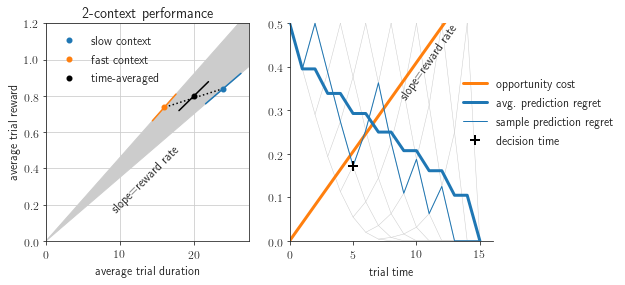

In [18]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
rho_context=[0.035,0.046]
T_context=[24,16]
T_avg=sum(T_context)/2
R_context=[rho*T for rho,T in zip(rho_context,T_context)]
R_avg=sum([R*T/sum(T_context) for R,T in zip(R_context,T_context)])
trial_time_vec=np.arange(para['T']+1+para['T_ITI'])
ax[0].set_ylim(0,1.2)
ax[0].set_xlim(0,para['T']+1+para['T_ITI']+4)
ax[0].set_ylabel('average trial reward')
ax[0].set_xlabel('average trial duration')
ax[0].set_title('2-context performance')
ax[0].text(8.5,0.48,'slope=reward rate',rotation=45)

lblstr=['slow context','fast context']
ax[0].fill_between(x=[0,2*T_context[0]],y1=[0,2*R_context[0]],y2=[0,2*1.5*R_context[1]],color=[0.8]*3)
ax[0].plot(T_context,R_context,':',color='k')
ax[0].plot([0.9*T_avg,1.1*T_avg],[0.9*R_avg,1.1*R_avg],'-',color='k')
for it,lbl in enumerate(lblstr):
#     ax[0].plot(trial_time_vec[trial_time_vec<=T_context[it]],rho_context[it]*trial_time_vec[trial_time_vec<=T_context[it]],'--',color='C'+str(it),lw=3)
    ax[0].plot([T_context[it]],[R_context[it]],'o',color='C'+str(it),ms=4,label=lbl,zorder=4)
    ax[0].plot([0.9*T_context[it],1.1*T_context[it]],[0.9*R_context[it],1.1*R_context[it]],'-',color='C'+str(it),ms=4,zorder=4)
ax[0].plot([T_avg],[R_avg],'o',color='k',ms=4,label='time-averaged')

ax[0].legend(frameon=False,loc=2)

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
#     ax.plot(np.arange(para['T']+1),1-rho_store[itvec[ait]+1]*np.arange(para['T']+1),'r')
        # ax.set_ylim(-0.5,1.5)
# ax.set_xlim(0,para['T'])
# ax.set_ylabel(r'Value, $V_{\textrm{act}}(n,t)$')
# ax.set_xlabel(r'time (steps)')
# ax.set_title(r'$\rho='+str(rhovec[0])+'$')
# ax.legend(frameon=False)

trial_time_vec=np.arange(para['T']+1)
ax[1].plot(trial_time_vec,opp_cost,'-',color='C1',lw=3,label='opportunity cost')
ax[1].plot(trial_time_vec,mean_regret,'-',color='C0',lw=3,label='avg. prediction regret')
ax[1].plot(trial_time_vec,regret,'-',color='C0',lw=1,label='sample prediction regret',clip_on=False)

ax[1].plot([t_decision],[regret[t_decision]],'k+',ms=10,clip_on=False,label='decision time')
# ax[1].set_ylabel(r'belief,$b_t$ (expected trial reward)')
ax[1].set_xlabel('trial time')
ax[1].set_ylim(0,0.5)
ax[1].set_xlim(0,para['T']+1)
# ax[1].text(0.5,1.1,r'\textbf{$baseline=(\rho_\textrm{short}-\rho_\textrm{long})T_\textrm{short}$}',color='C0',fontsize=10)
# ax[1].text(0.5,0.45,r'\textbf{$slope=\rho_\textrm{long}$}',color='C1',fontsize=10)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid('False')
ax[1].legend(frameon=False,bbox_to_anchor=[0.8,0.5,0.1,0.3])
ax[1].text(8.5,0.48,'slope=reward rate',rotation=55)
fig.savefig('regret_vs_oppcost.pdf', transparent=True,bbox_inches='tight',dpi=300)

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(8.5, 0.48, 'slope=reward rate')

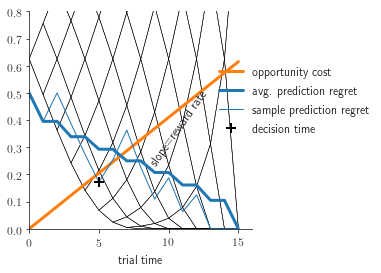

In [96]:
fig,ax=pl.subplots(1,1,figsize=(4,4))
rho_context=[0.035,0.046]
T_context=[24,16]
T_avg=sum(T_context)/2
R_context=[rho*T for rho,T in zip(rho_context,T_context)]
R_avg=sum([R*T/sum(T_context) for R,T in zip(R_context,T_context)])
trial_time_vec=np.arange(para['T']+1+para['T_ITI'])
bval=0.25
for b in [bval,bval]:
    for Nm in 2*np.arange(para['T']):
        ax.plot(np.arange(para['T']+1-Nm/2)+Nm/2,[(1+b)*get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0]*3,mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(para['T']):
        ax.plot(np.arange(para['T']+1-Np/2)+Np/2,[(1+b)*(1-get_pt_plus(t,Nt)) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0]*3,mew=0.5,mfc='k',mec='k')


trial_time_vec=np.arange(para['T']+1)
ax.plot(trial_time_vec,opp_cost,'-',color='C1',lw=3,label='opportunity cost')
ax.plot(trial_time_vec,mean_regret,'-',color='C0',lw=3,label='avg. prediction regret')
ax.plot(trial_time_vec,regret,'-',color='C0',lw=1,label='sample prediction regret',clip_on=False)

ax.plot([t_decision],[regret[t_decision]],'k+',ms=10,clip_on=False,label='decision time')
ax.set_xlabel('trial time')
ax.set_ylim(0,0.8)
ax.set_xlim(0,para['T']+1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid('False')
ax.legend(frameon=False,bbox_to_anchor=[0.8,0.5,0.1,0.3])
ax.text(8.5,0.48,'slope=reward rate',rotation=55)

## expected reward approximtion (Supp Fig.5)

In [9]:
from lib.lib import get_pt_plus
from functools import partial
from scipy.optimize import minimize

proposed approximation:

In [10]:
def Psfit(t,Nt,a,b):
    return 1/(1+np.exp(-(b+a*t)*Nt))

In [19]:
df_s=pd.DataFrame(index=pd.MultiIndex.from_product([range(para['T']+1),range(para['T']+1)]))
df_s['Nt']=[int(inds[0]-inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s['t']=[int(inds[0]+inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s=df_s.drop(df_s[df_s.t>para['T']].index) #drop rows having time>T 
df_s=df_s.drop((0,0))
df_s['Ptplus']=df_s.apply(lambda x: get_pt_plus(x.t,x.Nt,T=para['T']),axis=1) #add success probability
df_s.head()

Nt  t    Ptplus
0 1  -1  1  0.395264
  2  -2  2  0.290527
  3  -3  3  0.193848
  4  -4  4  0.113281
  5  -5  5  0.054688

In [20]:
def error_func(paras,Psfit,data):
    return np.sum(np.asarray([np.power(Psfit(datum.t,datum.Nt,paras[0],paras[1])-datum.Ptplus,2) for datum in data.itertuples()]))

In [21]:
error_func_part=partial(error_func,Psfit=Psfit,data=df_s[df_s.t<11])
init_paras=[0.1,0.1]
out_struct=minimize(error_func_part,init_paras)

In [61]:
out_struct.x

array([0.03724982, 0.35565026])

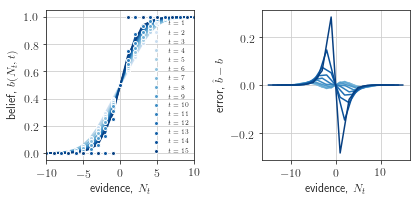

In [71]:
# err_Store=[]
# for err in np.linspace(0.09,0.11,11):
fig,ax=pl.subplots(1,2,figsize=(6,3))
cmap = sns.color_palette("Blues", n_colors=16)
df_s['Ptplusapp']=1/(1+np.exp(-(out_struct.x[1]+out_struct.x[0]*df_s.t)*df_s.Nt))
df_s['Ptpluserr']=(df_s['Ptplusapp']-df_s['Ptplus'])
grouped = df_s.groupby('t')
for key, group in grouped:
    ax[0].plot(group.Nt.values,group.Ptplusapp.values,'-',color=cmap[key],ms=2)
    ax[1].plot(group.Nt,group.Ptpluserr,'-',color=cmap[key],ms=2)

for key, group in grouped:
    ax[0].plot(group.Nt,group.Ptplus,'o',ms=4,mec='w',mew=1,mfc=cmap[key],label=r'$t='+str(key)+r'$')

ax[0].legend(frameon=False,prop={'size':6.3},loc=4)
ax[0].set_ylabel(r'belief, $b(N_t,t)$')
ax[1].set_ylabel(r'error, $\hat{b}-b$')
ax[0].set_xlabel(r'evidence, $N_t$')
ax[1].set_xlabel(r'evidence, $N_t$')
ax[0].set_xlim(-10,10)
fig.tight_layout()
fig.savefig('pplus_approx.pdf', transparent=True,bbox_inches="tight",dpi=300)

## Schematic fig.6a

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


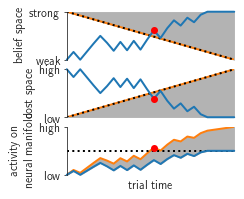

In [42]:
fig,ax=pl.subplots(3,1,figsize=(3,3))
l=26
t_decision=13
np.random.seed(8)
Ntvec=np.insert(np.cumsum(np.random.choice((-1,1),l-1)),0,0)
regret=np.array([get_pt_plus(t,Nt,T=l-1,p=0.5) for t,Nt in zip(np.arange(len(Ntvec)),Ntvec)])
regret=1-np.array([max((r,1-r)) for r in regret])
# regret=0.5*(1-regret)
# trial_time_vec=np.arange(para['T']+1)
trial_time_vec=np.linspace(0,l,l)
opp_cost=0.5*np.linspace(0,1,l)

bit=0
ax[bit].plot(trial_time_vec,1-opp_cost,'-',color='C1',lw=2,label='opportunity cost')
ax[bit].plot(trial_time_vec,1-opp_cost,':',color='k',lw=2,label='opportunity cost')
ax[bit].plot(trial_time_vec,1-regret,'-',color='C0',lw=2,label='avg. prediction regret',clip_on=False)
ax[bit].fill_between(trial_time_vec,1*np.ones((len(trial_time_vec),)),1-opp_cost,color=[0.7]*3)
ax[bit].plot([t_decision+0.5],[1-regret[t_decision]],'ro',ms=5,label='decision time')
ax[bit].set_ylim(0.5,1)
ax[bit].set_xlim(0,l)
ax[bit].set_xticks([])
ax[bit].set_yticks([0.5,1.0])
ax[bit].set_yticklabels(['weak','strong'])
ax[bit].set_ylabel('belief space')
ax[bit].spines['right'].set_visible(False)
ax[bit].spines['top'].set_visible(False)
ax[bit].spines['bottom'].set_visible(False)
ax[bit].grid('False')

cit=1
ax[cit].plot(trial_time_vec,opp_cost,'-',color='C1',lw=2,label='opportunity cost')
ax[cit].plot(trial_time_vec,opp_cost,'k:',color='k',lw=2)
ax[cit].plot(trial_time_vec,regret,'-',color='C0',lw=2,label='avg. prediction regret',clip_on=False)
ax[cit].fill_between(trial_time_vec,np.zeros((len(trial_time_vec),)),opp_cost,color=[0.7]*3)
ax[cit].plot([t_decision+0.5],[regret[t_decision]],'ro',ms=5,label='decision time')
ax[cit].set_ylim(0,0.5)
ax[cit].set_xlim(0,l)
ax[cit].set_xticks([])
ax[cit].set_yticks([0,0.5])
ax[cit].set_yticklabels(['low','high'])
ax[cit].set_ylabel('cost space')
ax[cit].spines['right'].set_visible(False)
ax[cit].spines['top'].set_visible(False)
ax[cit].spines['bottom'].set_visible(False)
ax[cit].grid('False')



bit=2
ax[bit].plot(trial_time_vec,1-regret+opp_cost,'-',color='C1',lw=2,label='opportunity cost')
ax[bit].plot(trial_time_vec,np.ones(opp_cost.shape),':',color='k',lw=2,label='opportunity cost')
ax[bit].plot(trial_time_vec,1-regret,'-',color='C0',lw=2,label='avg. prediction regret',clip_on=False)
ax[bit].fill_between(trial_time_vec,1-regret,1-regret+opp_cost,color=[0.7]*3)
ax[bit].plot([t_decision+0.5],[1-regret[t_decision]+opp_cost[t_decision]],'ro',ms=5,label='decision time')
ax[bit].set_ylim(0.5,1.5)
ax[bit].set_xlim(0,l)
ax[bit].set_xticks([])
ax[bit].set_yticks([0.5,1.5])
ax[bit].set_yticklabels(['low','high'])
ax[bit].set_ylabel('activity on \n neural manifold')
ax[bit].spines['right'].set_visible(False)
ax[bit].spines['top'].set_visible(False)
ax[bit].spines['bottom'].set_visible(False)
ax[bit].grid('False')
ax[bit].set_xlabel('trial time')

fig.savefig('neuro_schematic.pdf', transparent=True,bbox_inches="tight",dpi=300)